In [136]:
import numpy as np, matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from scipy import stats

def transcrip2rxn(lini, lini2, T, ks, ks2):
#%% Parameters:
    stoich = np.array([0, 1]);     # reaction orders
#%% initialize
    
    #%% current time
    t = 0; treport=100
    
    #%% initial population
    x = lini  # mRNA
    y = lini2 # protein p
    
    #%% histories
    ts = [t]
    ls = [x]
    ls2 = [y]
    
    #%%
    while t<T:
        if t>treport:                     # issue progress reports
            #print(t)
            treport=treport+100
        
        #define propensitiies
        a = (x**stoich) * ks
        atot = np.sum(a)   
        
        b0 = x * ks2[0]
        b1 = y * ks2[1]
        btot = b0 + b1
        
        tot = atot + btot # total rate for anything to happen
        
        #change time
        t = t - np.log(np.random.random())/tot
        
        # roll dice and change populations
        mu = 0
        r = np.random.random()
        if r >=0 and r <= (a[0]/(a[0]+a[1]+b0+b1)):
            mu = mu + 1
        elif r > (a[0]/(a[0]+a[1]+b0+b1)) and r <= ((a[0]+a[1])/(a[0]+a[1]+b0+b1)):
            mu = mu + 2
        elif r > ((a[0]+a[1])/(a[0]+a[1]+b0+b1)) and r <= ((a[0]+a[1]+b0)/(a[0]+a[1]+b0+b1)):
            mu = mu + 3
        elif r > ((a[0]+a[1]+b0)/(a[0]+a[1]+b0+b1)) and r <= ((a[0]+a[1]+b0+b1)/(a[0]+a[1]+b0+b1)):
            mu = mu + 4

        if mu == 1:
            x = x + 1
        elif mu == 2:
            x = x - 1
        elif mu == 3:
            y = y + 1
        elif mu == 4:
            y = y - 1
            
        #%% record Gillespie steps
        ts = ts + [t]
        ls = ls + [x]
        ls2 = ls2 +[y]
        
    return (np.array(ts), np.array(ls), np.array(ls2))

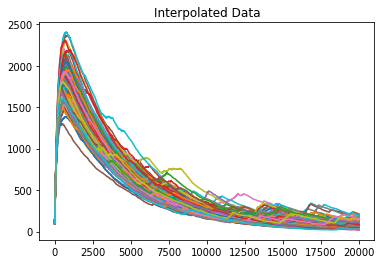

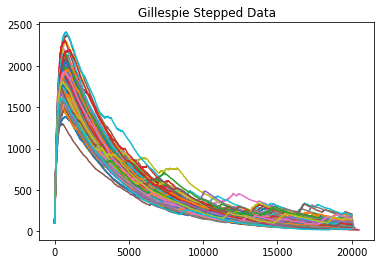

In [150]:
# running the Gillespie model

no_of_trials = 100

m_data = []
p_data = []
raw_data = []

for i in range(0, no_of_trials):
    #%% params
    lini = 50
    lini2 = 100
    runtime = 20000
    ks = np.array([5*(10**-4), 5*(10**-3)])
    ks2 = np.array([0.2, 2.5*(10**-4)])

    (ts, ls, ls2) = transcrip2rxn(lini, lini2, runtime, ks, ks2)
    
    tmin = np.min(ts)
    tmax = np.max(ts);
    tvals  = np.arange(tmin,tmax,(tmax/1000))

    def m_pop(t):
        ms = ks[0]/ks[1]
        m = ms*(1+((lini/ms)-1)*np.exp(-ks[1]*t))
        return m
    m_t = m_pop(tvals)

    # function that returns dP/dt
    def model(p,t):
        dpdt = (m_pop(t))*ks2[0] - p*ks2[1]
        return dpdt

    # solve ODE
    p_t = odeint(model,lini2,tvals)
    
    # interpolate
    
    mrna = interp1d(ts, ls)
    protein = interp1d(ts, ls2, kind = 'nearest')
    
    t_new = np.arange(0, runtime, 1)
    m_new = mrna(t_new)
    p_new = protein(t_new)
    
    #save data
    
    m_data.append(m_new)
    p_data.append(p_new)
    raw_data.append([ts, ls, ls2])

    # check interpolation
    
    """plt.plot(ts, ls2)
    plt.show()
    plt.plot(t_new, p_new, color = 'b')
    plt.show()
    
    p_new2 = protein(ts)
    chisq = stats.chisquare(p_new2, ls2)
    
    print(chisq)"""

# qualitatively compare interpolation

for i in range(0, len(p_data)):
    plt.plot(t_new, p_data[i])
plt.title('Interpolated Data')
plt.show()

for i in range(0, len(raw_data)):
    plt.plot(raw_data[i][0], raw_data[i][2])
plt.title('Gillespie Stepped Data')
plt.show()

In [151]:
### start data analysis

# find mean

p_data = np.array([p_data]).reshape(no_of_trials,runtime)
p_data = np.transpose(p_data)
avg_p = p_data.mean(axis=1)

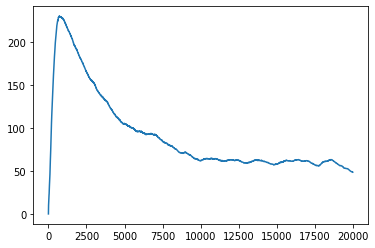

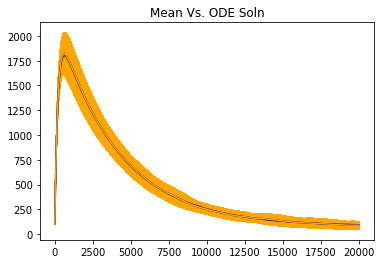

In [162]:
#find RMS

avg_p = avg_p.reshape(20000,1)
y_err = np.sqrt((((p_data - avg_p)**2).sum(axis=1))/(no_of_trials-1))

plt.plot(t_new, y)
plt.show()

plt.title('Mean Vs. ODE Soln')
plt.errorbar(t_new, avg_p, yerr = y_err, color = 'orange')
plt.plot(tvals, p_t, color = 'black')
plt.plot(t_new, avg_p, color = 'blue')
plt.show()